# Compare Visual with Musical interface - GLM

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from nilearn import plotting

from src.my_settings import settings

sett = settings()

In [4]:
music_path = "/Volumes/T7/BIDS-MUSICNF/derivatives/nilearn-glm"
visual_path = "/Volumes/T7/BIDS-INTERHEMISPHERIC-NF/derivatives/nilearn-glm"

In [5]:
# List all zmap nii.gz files
zmap_music_files = glob.glob(
    os.path.join(
        music_path,
        "sub-*_task-nf_space-MNI152NLin2009cAsym_stat-z_con-MotorImageryOneTwo.nii.gz",
    )
)
zmap_music_files.sort()

zmap_visual_files = glob.glob(os.path.join(visual_path, "sub-*_task-nf_stat-z_con-MotorImagery.nii.gz"))
zmap_visual_files.sort()

n_subjects_music = len(zmap_music_files)
n_subjects_visual = len(zmap_visual_files)
print(f"Found {n_subjects_music} music subjects and {n_subjects_visual} visual subjects")

Found 22 music subjects and 10 visual subjects


In [6]:
second_level_input = zmap_music_files + zmap_visual_files

In [7]:
condition_effect = np.hstack(([1] * n_subjects_music, [-1] * n_subjects_visual))
condition_effect

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

<Axes: label='conditions', ylabel='scan number'>

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


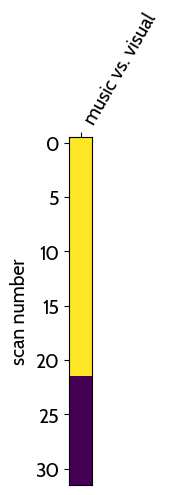

In [8]:
unpaired_design_matrix = pd.DataFrame(condition_effect[:, np.newaxis], columns=["music vs. visual"])

plotting.plot_design_matrix(unpaired_design_matrix, rescale=False)

In [9]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import resample_to_img

# Resample images to the first image in the list
reference_img = second_level_input[0]
resampled_second_level_input = [resample_to_img(img, reference_img, interpolation="nearest") for img in second_level_input]

# Fit the second-level model with resampled images
second_level_model_unpaired = SecondLevelModel(n_jobs=2, smoothing_fwhm=8).fit(resampled_second_level_input, design_matrix=unpaired_design_matrix)

stat_maps_unpaired = second_level_model_unpaired.compute_contrast("music vs. visual", output_type="all")

/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_44633/792034239.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_second_level_input = [resample_to_img(img, reference_img, interpolation="nearest") for img in second_level_input]
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_44633/792034239.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_second_level_input = [resample_to_img(i

Threshold: 4.889218422212778


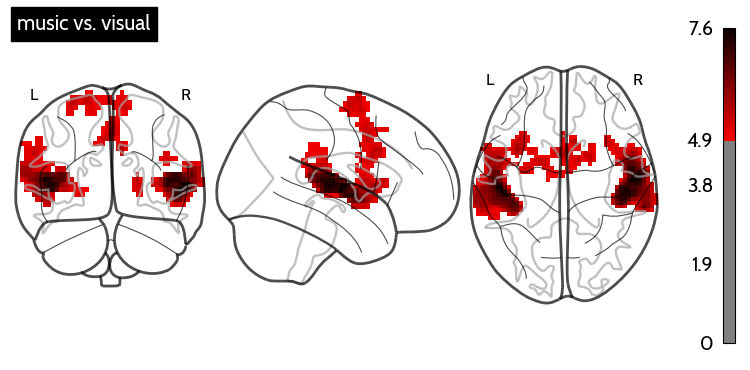

In [10]:
from nilearn.glm import threshold_stats_img

alpha = 0.05
hc = "bonferroni"
ct = 10

corrected_map, thres = threshold_stats_img(stat_maps_unpaired["z_score"], cluster_threshold=ct, alpha=alpha, height_control=hc)

print(f"Threshold: {thres}")

display = plotting.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    # plot_abs=False,
    title="music vs. visual",
)

Music vs. Visual | Imagery | bonferroni(0.05) | k>10


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



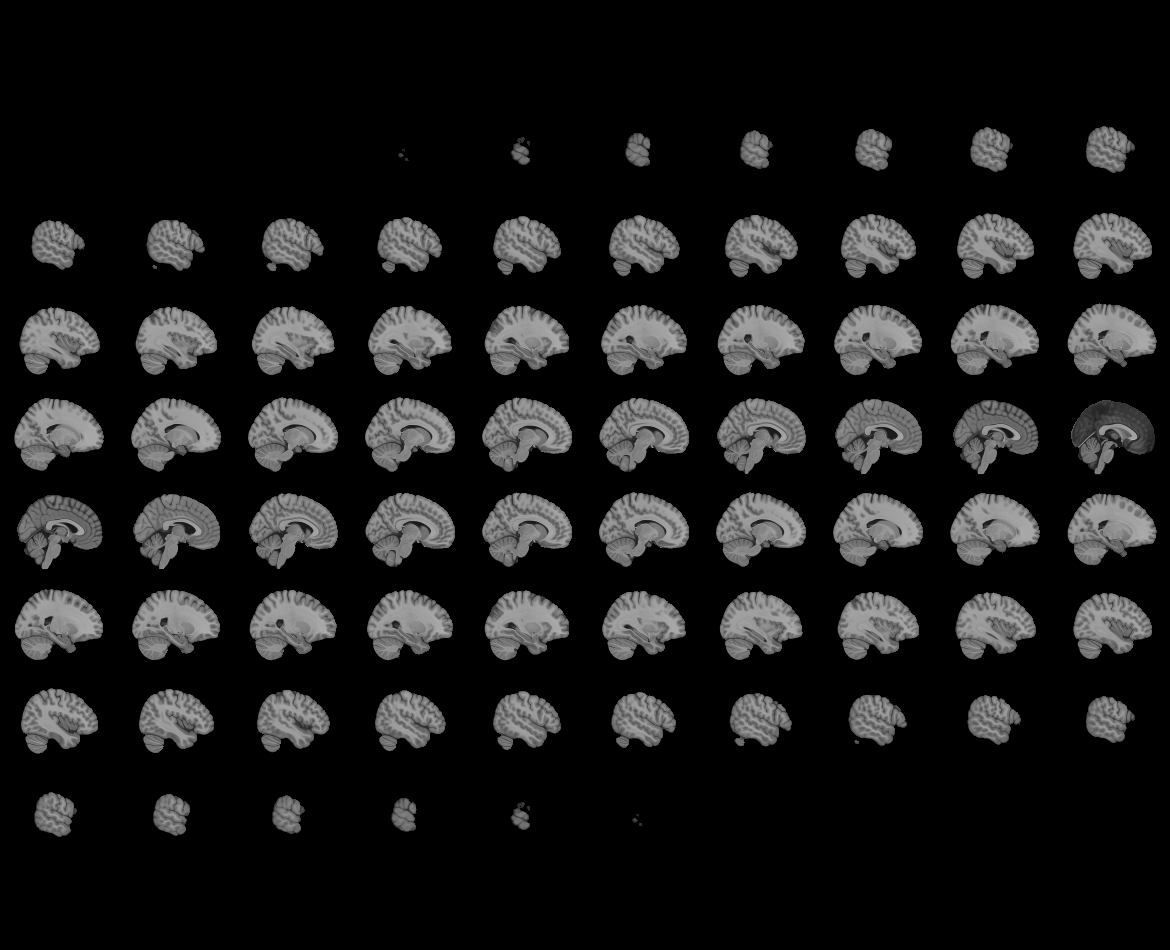
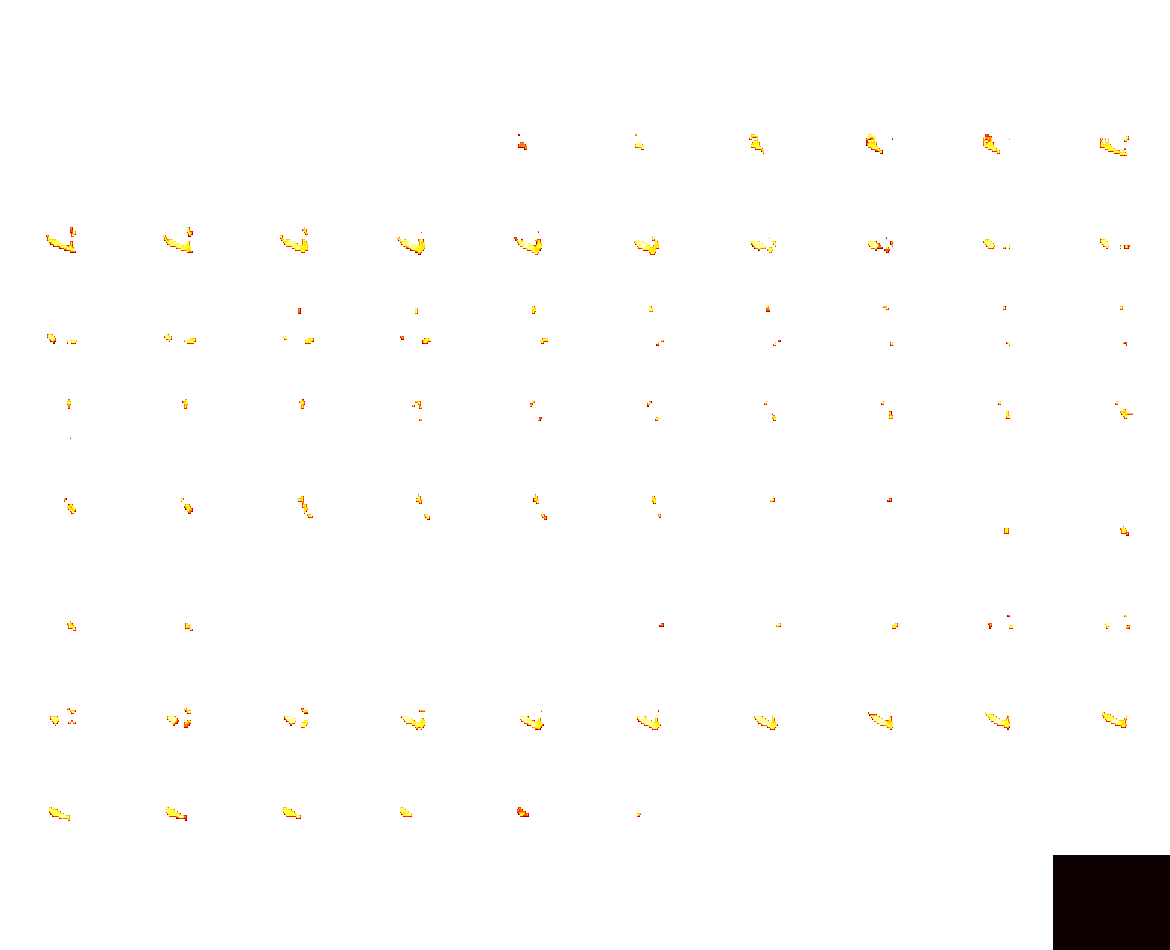

In [11]:
# | label: fig-musicVSvisual-glm-map
print(f"Music vs. Visual | Imagery | {hc}({alpha}) | k>{ct}")
plotting.view_img(corrected_map, threshold=thres, colorbar=True)

In [12]:
# | label: tab-musicVSvisual-glm-clusters
# cluster table
from nilearn.reporting import get_clusters_table
from mni_to_atlas import AtlasBrowser

atlas = AtlasBrowser("AAL3")

table = get_clusters_table(stat_maps_unpaired["z_score"], thres, cluster_threshold=ct)

# AAL3 labelling
coordinates = table[["X", "Y", "Z"]].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table["AAL3"] = aal_labels
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,60.0,-9.0,5.79,7.583699,17775,Heschl_R
1,1a,51.0,-24.0,9.78,7.281549,,Temporal_Sup_R
2,1b,54.0,-3.0,-2.19,7.279964,,Temporal_Sup_R
3,1c,63.0,-33.0,13.77,6.726964,,Temporal_Sup_R
4,2,-51.0,-18.0,9.78,7.441648,22156,Temporal_Sup_L
5,2a,-39.0,-30.0,9.78,6.824635,,Temporal_Sup_L
6,2b,-51.0,-6.0,1.80,6.555337,,Temporal_Sup_L
7,2c,-57.0,3.0,1.80,5.902738,,Rolandic_Oper_L
8,3,9.0,18.0,33.72,5.598578,610,Cingulate_Mid_R
9,4,-30.0,-6.0,69.63,5.556047,6966,Frontal_Sup_2_L


In [13]:
table.to_clipboard(index=False)

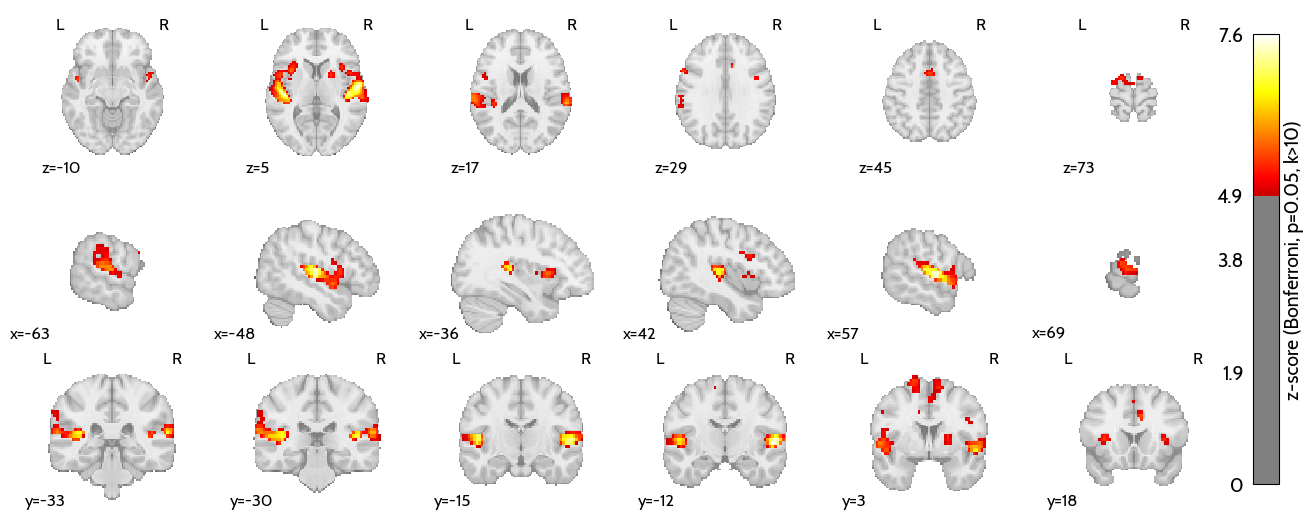

In [14]:
P_MV = plotting.plot_stat_map(
    corrected_map,
    threshold=thres,
    colorbar=True,
    draw_cross=False,
    display_mode="mosaic",
    cut_coords=6,
)

# Add colorbar text
P_MV._cbar.set_label("z-score (Bonferroni, p=0.05, k>10)")